In [1]:
import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import random
import scanpy as sc
import scglue
import tqdm
from matplotlib import rcParams
from matplotlib.pyplot import rc_context

/root/miniconda3/envs/sclab/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
scglue.plot.set_publication_params()
rcParams["figure.figsize"] = (4, 4)

In [3]:
metadata = pd.read_csv('/lmh_data/data/sclab/GSE223917/GSE223917_HiRES_emb_metadata.csv')
hic = anndata.read_h5ad("/lmh_data/data/sclab/GSE223917/scHiC.h5ad")
hic_pca_data = pd.read_csv('/lmh_data/data/sclab/GSE223917/BandNorm/embedding_all.txt', sep='\t')
rna = anndata.read_h5ad("/lmh_data/data/sclab/GSE223917/scRNA.h5ad")

metadata = metadata.set_index('Cellname')
hic.obs.index = hic.obs.index.str.split('.').str[0]
hic_pca_data.index = hic_pca_data.index.str.split('.').str[0]

In [4]:
metadata

,Rawreads,DNAreads,RNAreads,y/x,Raw contacts,Dedup contacts,Clean1 contacts,Clean2 contacts,Clean3 contacts,Clean3 inter-contacts,...,farAvg,repli score,G1S.Score,G2M.Score,Stage,Celltype,RMSD 20k,CDPS cluster,Sub_k_cluster,Cellcycle phase
Cellname,,,,,,,,,,,,,,,,,,,,,
GasaE751001,0.788963,0.704156,0.073214,0.010131,293142,181153,180220,135168,135083,12777,...,20006475.72,0.715816,1.381101,-0.574054,E75,ExE ectoderm,22.312863,9,2,M
GasaE751002,1.194513,1.117651,0.065995,0.028088,593838,314892,313340,271260,271140,75034,...,27242188.33,1.367934,-0.815665,1.939633,E75,neural ectoderm,0.891031,11,3,Late-S
GasaE751003,1.006697,0.938163,0.059082,0.021442,398891,237120,236101,201489,201397,33630,...,22880309.80,-0.022495,-0.668652,1.498710,E75,ExE mesoderm,1.100645,7,1,Late-S
GasaE751004,1.127121,1.019122,0.094307,0.021927,407136,235032,233832,201953,201865,8739,...,13854623.40,-0.404727,-0.139662,-0.722376,E75,early mesenchyme,25.845133,4,3,M
GasaE751005,2.841285,2.650203,0.166877,0.023697,1095973,298522,295620,252964,252803,13012,...,18797081.50,-1.146512,1.143928,0.253611,E75,ExE endoderm,13.713743,4,1,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OrgeEX053380,2.449614,2.353684,0.074256,0.007859,541060,305194,303887,271424,271295,55341,...,33596660.72,0.550920,-0.192434,-0.549379,EX05,mix late mesenchyme,0.701147,3,1,Early-S
OrgeEX053381,2.016824,1.961743,0.038495,0.020611,440947,262534,261214,232481,232394,45535,...,39136989.58,-0.577376,0.495535,-0.825063,EX05,mix late mesenchyme,0.867019,11,1,G1
OrgeEX053382,2.242817,2.147959,0.074411,0.005367,462067,285690,284629,250546,250416,41589,...,32189265.97,0.757895,0.126002,0.412224,EX05,mix late mesenchyme,0.939780,3,1,Early-S


In [5]:
metadata['Cellcycle phase'].unique()

array(['M', 'Late-S', 'Mid-S', 'Early-S', 'G2', 'G1', 'G0'], dtype=object)

In [6]:
metadata['Stage'].unique()

array(['E75', 'E70', 'E80', 'E95', 'EX15', 'E85', 'EX05'], dtype=object)

In [7]:
metadata['Celltype'].unique()

array(['ExE ectoderm', 'neural ectoderm', 'ExE mesoderm',
       'early mesenchyme', 'ExE endoderm', 'mitosis', 'blood',
       'early mesoderm', 'epithelial cells', 'endoderm',
       'epiblast and PS', 'NMP', 'neural tube', 'intermediate mesoderm',
       'radial glias', 'oligodendrocytes and progenitors',
       'mix late mesenchyme', 'early neurons', 'schwann cell precursors',
       'notochord', 'myocytes'], dtype=object)

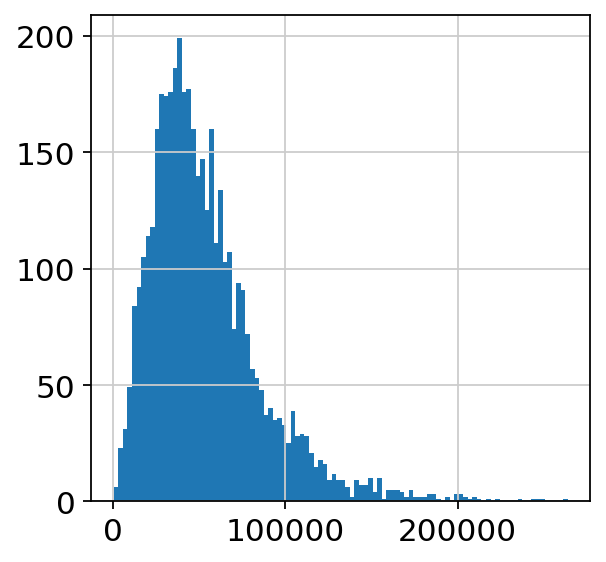

In [8]:
_metadata = metadata.copy()
# _metadata = _metadata[_metadata['Cellcycle phase'].isin(['Late-S', 'Mid-S', 'Early-S'])]
# _metadata = _metadata[_metadata['Cellcycle phase'].isin(['G1', 'Early-S', 'Mid-S'])]
_metadata = _metadata[_metadata['Cellcycle phase'].isin(['G0', 'Late-S', 'Mid-S'])]

# _metadata = _metadata[_metadata['Stage'].isin(['EX05', 'EX15'])]


plt.hist(_metadata['Clean3 inter-contacts'], 100)
plt.show()

In [9]:
_metadata = _metadata[(_metadata['Clean3 inter-contacts']>10000)&(_metadata['Clean3 inter-contacts']<60000)]
_metadata['Celltype'].value_counts()

mix late mesenchyme                 459
early neurons                       316
blood                               275
ExE endoderm                        261
radial glias                        180
ExE ectoderm                        164
neural ectoderm                     153
early mesoderm                      113
intermediate mesoderm               112
early mesenchyme                    101
epithelial cells                    100
ExE mesoderm                         96
epiblast and PS                      93
neural tube                          68
oligodendrocytes and progenitors     66
notochord                            54
endoderm                             43
myocytes                             31
NMP                                  25
schwann cell precursors              25
mitosis                              18
Name: Celltype, dtype: int64

In [10]:
concern_celltype = _metadata['Celltype'].value_counts().index[_metadata['Celltype'].value_counts()>150]
concern_celltype
# concern_celltype = [
#     'mix late mesenchyme', 'early neurons', 'blood',
#     'ExE endoderm', 'radial glias', 'ExE ectoderm', 'neural ectoderm'
# ]

Index(['mix late mesenchyme', 'early neurons', 'blood', 'ExE endoderm',
       'radial glias', 'ExE ectoderm', 'neural ectoderm'],
      dtype='object')

In [11]:
index = _metadata[_metadata['Celltype'].isin(concern_celltype)].index
index = index.intersection(hic.obs.index).intersection(hic_pca_data.index).intersection(rna.obs.index)
hic, hic_pca_data, rna = hic[index], hic_pca_data.loc[index, :], rna[index]

/tmp/ipykernel_309359/2649854083.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  hic.obs['cell_type'] = _metadata['Celltype']
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:325: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = ax.scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:325: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = ax.scatter(


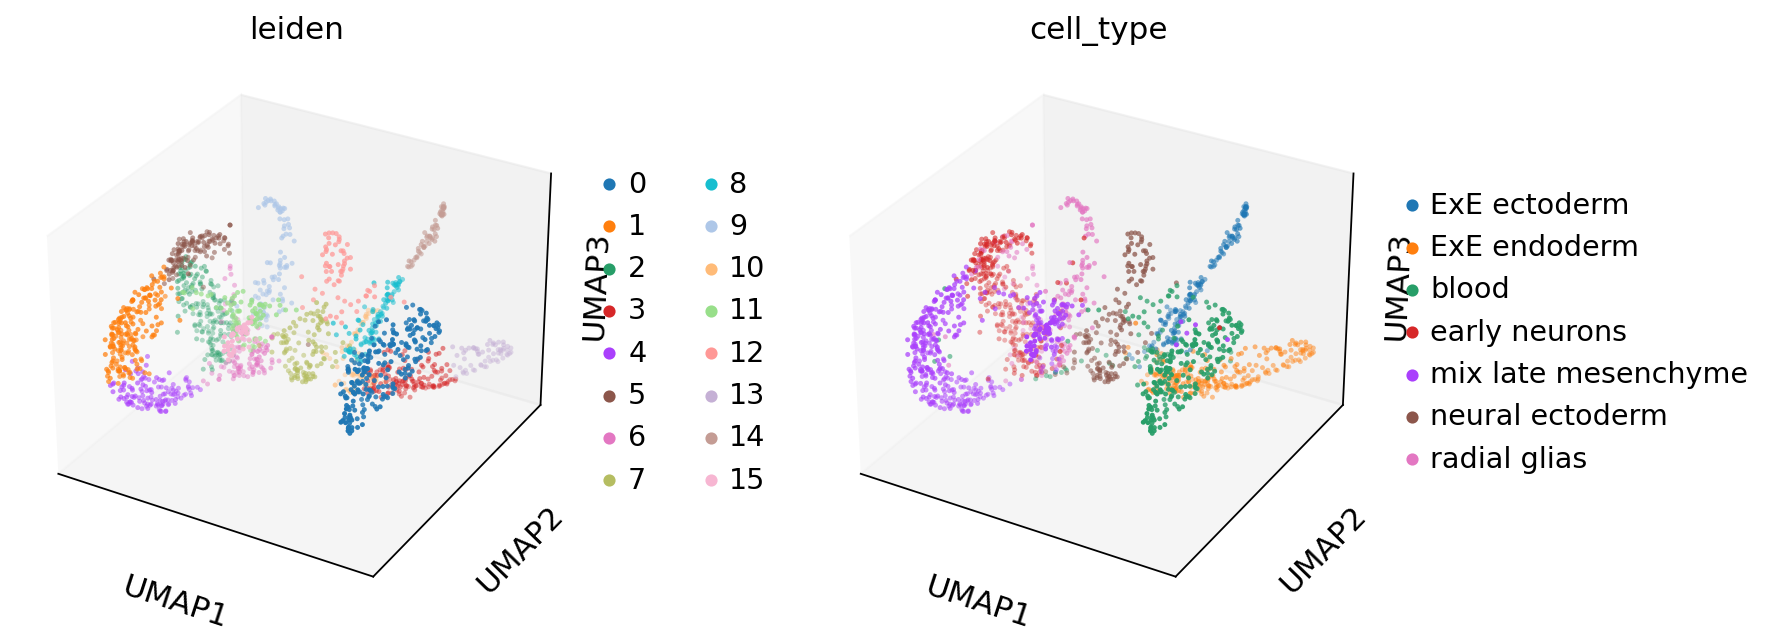

In [12]:
hic.obs['cell_type'] = _metadata['Celltype']
hic.obsm["X_pca"] = hic_pca_data.to_numpy()

def hic_pca():
    sc.pp.neighbors(hic, use_rep="X_pca", metric="cosine")
#     sc.tl.umap(hic)
    sc.tl.umap(hic, n_components=3)
    sc.tl.leiden(hic)
hic_pca()
with rc_context({'figure.figsize': (5, 5)}):
#     sc.pl.umap(hic, color=['leiden', 'cell_type'], add_outline=True, legend_loc='on data',
#                legend_fontsize=12, legend_fontoutline=2, frameon=False, palette='Set1')
    sc.pl.umap(hic, color=["leiden", "cell_type"], add_outline=True, projection='3d')

/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Pa

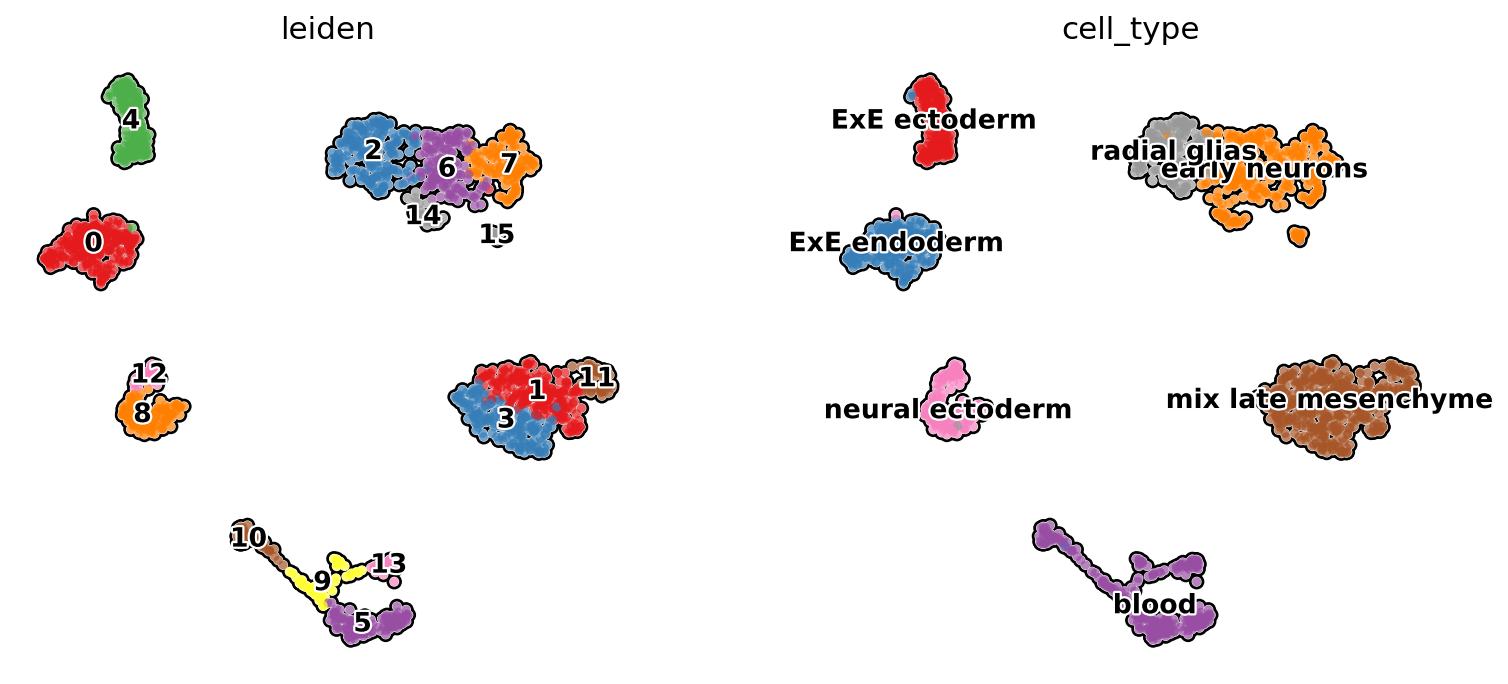

In [13]:
rna.layers["counts"] = rna.X.copy()

scglue.data.get_gene_annotation(
    rna, gtf="/lmh_data/data/sclab/GSE223917/gencode.vM23.annotation.gtf",
    gtf_by="gene_name"
)
rna = rna[:, rna.var.dropna(axis=0, how='all').index]

def rna_pca(rna):
    rna.X = rna.layers["counts"].copy()
    sc.pp.highly_variable_genes(rna, n_top_genes=2000, flavor="seurat_v3")
    sc.pp.normalize_total(rna)
    sc.pp.log1p(rna)
    sc.pp.scale(rna)
    sc.tl.pca(rna, n_comps=100, svd_solver="auto")

    sc.pp.neighbors(rna, metric="cosine")
    sc.tl.umap(rna)
    sc.tl.leiden(rna)
rna_pca(rna)
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(rna, color=['leiden', 'cell_type'], add_outline=True, legend_loc='on data',
               legend_fontsize=12, legend_fontoutline=2, frameon=False, palette='Set1')

In [14]:
hic.var['chrom'] = [info[0] for info in hic.var_names.str.split('_')]
hic.var['chromStart'] = [int(info[1]) for info in hic.var_names.str.split('_')]
hic.var['chromEnd'] = hic.var['chromStart'] + 10000
hic.var

,chrom,start,chromStart,chromEnd
chr1_0,chr1,0,0,10000
chr1_10000,chr1,10000,10000,20000
chr1_20000,chr1,20000,20000,30000
chr1_30000,chr1,30000,30000,40000
chr1_40000,chr1,40000,40000,50000
...,...,...,...,...
chrX_170990000,chrX,170990000,170990000,171000000
chrX_171000000,chrX,171000000,171000000,171010000
chrX_171010000,chrX,171010000,171010000,171020000
chrX_171020000,chrX,171020000,171020000,171030000


In [15]:
sc.tl.rank_genes_groups(rna, 'cell_type', method='t-test')
marker_genes = pd.DataFrame(rna.uns['rank_genes_groups']['names'])[:1000]
marker_genes_index = marker_genes.values.reshape(-1)
_index = set(rna.var[rna.var['highly_variable']==True].index) & set(marker_genes_index)
rna.var['highly_variable'] = False
rna.var.loc[_index, 'highly_variable'] = True
rna.var

/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


,chrom,chromStart,chromEnd,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,...,mgi_id,havana_gene,tag,highly_variable,highly_variable_rank,means,variances,variances_norm,mean,std
gene,,,,,,,,,,,,,,,,,,,,,
0610005C13Rik,chr7,45567793,45575327,0610005C13Rik,.,-,.,.,.,.,...,MGI:1918911,OTTMUSG00000030340.4,NaN,False,NaN,0.084931,0.137141,1.209202,0.043402,0.169486
0610006L08Rik,chr7,74818817,74853813,0610006L08Rik,.,-,.,.,.,.,...,MGI:1923503,OTTMUSG00000058385.1,overlapping_locus,False,NaN,0.026477,0.028997,0.993811,0.015608,0.102269
0610009B22Rik,chr11,51685385,51688874,0610009B22Rik,.,-,.,.,.,.,...,MGI:1913300,OTTMUSG00000005608.1,NaN,False,NaN,0.017837,0.024222,1.274203,0.010132,0.087236
0610009E02Rik,chr2,26445695,26459390,0610009E02Rik,.,+,.,.,.,.,...,MGI:3698435,OTTMUSG00000012797.1,overlapping_locus,False,NaN,0.136102,0.130549,0.647978,0.092817,0.233116
0610009L18Rik,chr11,120348677,120351190,0610009L18Rik,.,+,.,.,.,.,...,MGI:1914088,OTTMUSG00000004146.2,NaN,False,NaN,0.002508,0.003479,1.442877,0.001106,0.024766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wfdc12,chr2,164189230,164190608,Wfdc12,.,-,.,.,.,.,...,MGI:2183434,OTTMUSG00000001077.2,NaN,False,NaN,0.000000,0.000000,0.000000,0.000000,1.000000
Xcl1,chr1,164931643,164935527,Xcl1,.,-,.,.,.,.,...,MGI:104593,OTTMUSG00000026875.1,NaN,False,NaN,0.000000,0.000000,0.000000,0.000000,1.000000
Zcchc9-ps,chr2,141127279,141128065,Zcchc9-ps,.,+,.,.,.,.,...,MGI:3651106,OTTMUSG00000015604.1,overlapping_locus,False,NaN,0.000557,0.000279,0.618984,0.000523,0.015650


In [16]:
rna.var['chrom'].unique()

['chr7', 'chr11', 'chr2', 'chr17', 'chr16', ..., 'chr13', 'chr19', 'chr14', 'chrY', 'chrM']
Length: 22
Categories (22, object): ['chr1', 'chr2', 'chr3', 'chr4', ..., 'chr19', 'chrM', 'chrX', 'chrY']

In [17]:
import collections
import pybedtools

from pybedtools.cbedtools import Interval
from scglue.check import check_deps
from scglue.genomics import Bed
from tqdm.auto import tqdm
from typing import Any, Callable, Mapping, Optional, Union

def interval_dist(x: Interval, y: Interval) -> int:
    r"""
    Compute distance and relative position between two bed intervals

    Parameters
    ----------
    x
        First interval
    y
        Second interval

    Returns
    -------
    dist
        Signed distance between ``x`` and ``y``
    """
    if x.chrom != y.chrom:
        return np.inf * (-1 if x.chrom < y.chrom else 1)

    _start1, _end1 = (x.stop, x.start) if x.strand == '-' else (x.start, x.stop)
    _start2, _end2 = (y.stop, y.start) if y.strand == '-' else (y.start, y.stop)
    
    d = _start1-_start2
#     d = min(abs(_start1-_start2), abs(_end1-_start2))
#     if abs(d) <= 10000:
#         d = 0

    x_range = set([i for i in range(int(x.start/10000)*10000, int(x.end/10000)*10000+10000, 10000)])
    y_range = set([i for i in range(y.start, y.end+10000, 10000)])
    if x_range&y_range:
        d = 0

    return d
        
#     if x.start < y.stop and y.start < x.stop:
#         return 0
#     if x.stop <= y.start:
#         return x.stop - y.start - 1
#     if y.stop <= x.start:
#         return x.start - y.stop + 1

def window_graph(
        left: Union[Bed, str], right: Union[Bed, str], window_size: int,
        left_sorted: bool = False, right_sorted: bool = False,
        attr_fn: Optional[Callable[[Interval, Interval, float], Mapping[str, Any]]] = None
) -> nx.MultiDiGraph:
    r"""
    Construct a window graph between two sets of genomic features, where
    features pairs within a window size are connected.

    Parameters
    ----------
    left
        First feature set, either a :class:`Bed` object or path to a bed file
    right
        Second feature set, either a :class:`Bed` object or path to a bed file
    window_size
        Window size (in bp)
    left_sorted
        Whether ``left`` is already sorted
    right_sorted
        Whether ``right`` is already sorted
    attr_fn
        Function to compute edge attributes for connected features,
        should accept the following three positional arguments:

        - l: left interval
        - r: right interval
        - d: signed distance between the intervals

        By default no edge attribute is created.

    Returns
    -------
    graph
        Window graph
    """
    if isinstance(left, Bed):
        pbar_total = len(left)
        left = left.to_bedtool()
    else:
        pbar_total = None
        left = pybedtools.BedTool(left)
    if not left_sorted:
        left = left.sort(stream=True)
    left = iter(left)  # Resumable iterator
    if isinstance(right, Bed):
        right = right.to_bedtool()
    else:
        right = pybedtools.BedTool(right)
    if not right_sorted:
        right = right.sort(stream=True)
    right = iter(right)  # Resumable iterator

    attr_fn = attr_fn or (lambda l, r, d: {})
    if pbar_total is not None:
        left = tqdm(left, total=pbar_total, desc="window_graph")
    graph = nx.MultiDiGraph()
    window = collections.OrderedDict()  # Used as ordered set
    searched_chrom = set()
    for l in left:
        searched_chrom.add(l.chrom)
        for r in list(window.keys()):  # Allow remove during iteration
            if r.chrom != l.chrom and r.chrom in searched_chrom:
                del window[r]
                continue
            d = interval_dist(l, r)
            if -window_size <= d <= window_size:
                graph.add_edge(l.name, r.name, **attr_fn(l, r, d))
        else:
            for r in right:  # Resume from last break
                d = interval_dist(l, r)
                window[r] = None
                if np.isinf(d):
                    break
                if -window_size <= d <= window_size:
                    graph.add_edge(l.name, r.name, **attr_fn(l, r, d))
    pybedtools.cleanup()
    return graph

import itertools
import networkx as nx

rna_bed = scglue.genomics.Bed(rna.var.assign(name=rna.var_names))
hic_bed = scglue.genomics.Bed(hic.var.assign(name=hic.var_names))

rna_bed = rna_bed.expand(5000, 0)

def _dist_power_decay(x: int) -> float:
    return ((x + 10000) / 10000) ** (-0.75)
graph = window_graph(
    rna_bed, hic_bed, window_size=10000,
    attr_fn=lambda l, r, d, s=1: {
        "dist": abs(d), "weight": _dist_power_decay(abs(d)), "sign": s
    }
)

rgraph = graph.reverse()
nx.set_edge_attributes(graph, "fwd", name="type")
nx.set_edge_attributes(rgraph, "rev", name="type")
graph = scglue.graph.compose_multigraph(graph, rgraph)

hvg_reachable = scglue.graph.reachable_vertices(graph, rna.var.query("highly_variable").index)
hic.var["highly_variable"] = [
    item in hvg_reachable for item in hic.var_names
]

all_features = set(itertools.chain.from_iterable(
    map(lambda x: x.var_names, [rna, hic])
))
for item in all_features:
    graph.add_edge(item, item, weight=1.0, sign=1, type="loop")

window_graph: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50463/50463 [37:11<00:00, 22.62it/s]


In [18]:
hic.var.query("highly_variable").index

Index(['chr1_3190000', 'chr1_3200000', 'chr1_3210000', 'chr1_3220000',
       'chr1_3230000', 'chr1_3240000', 'chr1_3250000', 'chr1_3260000',
       'chr1_3270000', 'chr1_3280000',
       ...
       'chrX_169920000', 'chrX_169930000', 'chrX_169940000', 'chrX_169950000',
       'chrX_169960000', 'chrX_169970000', 'chrX_169980000', 'chrX_169990000',
       'chrX_170000000', 'chrX_170010000'],
      dtype='object', length=40406)

In [19]:
graph.number_of_nodes(), graph.number_of_edges()

(313852, 881976)

In [20]:
all(graph.has_node(gene) for gene in rna.var_names), \
all(graph.has_node(peak) for peak in hic.var_names), \
all(graph.has_edge(gene, gene) for gene in rna.var_names), \
all(graph.has_edge(peak, peak) for peak in hic.var_names), \
all(graph.has_edge(j, i) for i, j, _ in graph.edges)

(True, True, True, True, True)

In [21]:
hic.var.head()

,chrom,start,chromStart,chromEnd,highly_variable
chr1_0,chr1,0,0,10000,False
chr1_10000,chr1,10000,10000,20000,False
chr1_20000,chr1,20000,20000,30000,False
chr1_30000,chr1,30000,30000,40000,False
chr1_40000,chr1,40000,40000,50000,False


In [22]:
rna.write("/lmh_data/data/sclab/GSE223917/rna_preprocessed.h5ad", compression="gzip")
hic.write("/lmh_data/data/sclab/GSE223917/hic_preprocessed.h5ad", compression="gzip")
nx.write_graphml(graph, "/lmh_data/data/sclab/GSE223917/prior.graphml.gz")